# ISIC datasets in Kaggle

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import numpy as np
import mlcroissant as mlc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import json
import os
import re

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = '/Users/veronhoxha/.kaggle'

kaggle_username = os.getenv('KAGGLE_USERNAME')
kaggle_key = os.getenv('KAGGLE_KEY')

SEED = 42

In [4]:
api = KaggleApi()
api.authenticate()

### Number of total datasets with word "ISIC" in the title in Kaggle

In [5]:
search_term = 'ISIC'
datasets_list = []
datasets_list_description = []
page = 1

while True:
    datasets = api.dataset_list(search=search_term, page=page)
    if not datasets:
        break
    for dataset in datasets:
        if search_term.lower() in dataset.title.lower():
            datasets_list.append(dataset)
        elif search_term.lower() in dataset.description.lower():
            datsets_lists_description.append(dataset)
    page += 1

print(f"Total datasets found with 'ISIC' in the title: {len(datasets_list)}")
print(f"Total datasets found with 'ISIC' in the description: {len(datasets_list_description)}")

Total datasets found with 'ISIC' in the title: 858
Total datasets found with 'ISIC' in the description: 0


In [6]:
# converting all sizes to bytes

def parse_size(size_str):
    size_str = size_str.strip()
    size_regex = r'([\d\.]+)\s*([KMGT]?B)'
    match = re.match(size_regex, size_str, re.IGNORECASE)
    if not match:
        return None, None
    size_value, unit = match.groups()
    size_value = float(size_value)
    unit = unit.upper()
    units = {
        'B': 1,
        'KB': 1024,
        'MB': 1024 ** 2,
        'GB': 1024 ** 3,
        'TB': 1024 ** 4,
    }
    size_in_bytes = size_value * units.get(unit, 1)
    
    return size_in_bytes, unit

In [7]:
# flatting metadata since we are working with nested dictionary and list 

def flatten_metadata(metadata, parent_key='', sep='.'):
    items = []
    for k, v in metadata.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_metadata(v, new_key, sep=sep).items())
        elif isinstance(v, list):
            if all(isinstance(i, dict) for i in v):
                for idx, item in enumerate(v):
                    items.extend(flatten_metadata(item, f"{new_key}_{idx}", sep=sep).items())
            else:
                items.append((new_key, '; '.join(map(str, v))))
        else:
            items.append((new_key, v))
    return dict(items)

In [8]:
# collecting metadata

def convert_dataset_to_croissant(dataset):
    if dataset.tags:
        keywords = [tag.name for tag in dataset.tags]
    else:
        keywords = []
    
    # parsing the dataset.size
    size_in_bytes = None
    if dataset.size:
        try:
            size_in_bytes = float(dataset.size)
        except ValueError:
            size_in_bytes, size_unit = parse_size(dataset.size)
        except TypeError:
            size_in_bytes = None
    else:
        size_in_bytes = None
    
    # converting the size to MB
    if size_in_bytes:
        content_size_mb = size_in_bytes / (1024 * 1024)
        content_size_str = f"{content_size_mb}"
    else:
        content_size_str = "Unknown"
    
    owner_username = dataset.ref.split('/')[0]
    
    croissant_metadata = {
        "@context": {
            "@language": "en",
            "@vocab": "https://schema.org/",
            # there is a lot of other metadata here but i dont need them for now at least
        },
        "@type": "Dataset",
        "name": dataset.title,
        "alternateName": dataset.subtitle if dataset.subtitle else '',
        "description": dataset.description if dataset.description else '',
        "url": f"https://www.kaggle.com/{dataset.ref}",
        "identifier": dataset.id,
        "creator": {
            "@type": "Person",
            "name": dataset.creatorName if dataset.creatorName else owner_username,
            "url": f"https://www.kaggle.com/{owner_username}"
        },
        "license": {
            "@type": "CreativeWork",
            "name": dataset.licenseName
        },
        "keywords": keywords,
        "dateModified": dataset.lastUpdated.isoformat() if dataset.lastUpdated else None,
        "isAccessibleForFree": True,
        "distribution": [
            {
                "@type": "DataDownload",
                "contentUrl": f"https://www.kaggle.com/datasets/{dataset.ref}/download",
                "contentSize": content_size_str,
                "encodingFormat": "application/zip"
            }
        ],
        "isPrivate": dataset.isPrivate,
        "downloadCount": dataset.downloadCount,
        "viewCount": dataset.viewCount,
        "voteCount": dataset.voteCount,
        "usabilityRating": dataset.usabilityRating,
        "conformsTo": "http://mlcommons.org/croissant/1.0"
    }
    return croissant_metadata

In [9]:
croissant_metadata_list = []
for dataset in datasets_list:
    croissant_metadata = convert_dataset_to_croissant(dataset)
    croissant_metadata_list.append(croissant_metadata)

data_rows = []
for metadata in croissant_metadata_list:
    flattened_metadata = flatten_metadata(metadata)
    data_rows.append(flattened_metadata)

df = pd.DataFrame(data_rows)

# renaming some columns for clarity
df.rename(columns={
    'distribution_0.contentSize': 'contentSize',
    'distribution_0.contentUrl': 'contentUrl',
    'distribution_0.encodingFormat': 'encodingFormat'
}, inplace=True)

df.to_csv('../data/01_isic_datasets_metadata.csv', index=False)
print("Metadata saved to '01_isic_datasets_metadata.csv'")

Metadata saved to '01_isic_datasets_metadata.csv'


In [10]:
df = pd.read_csv('../data/01_isic_datasets_metadata.csv')

In [11]:
df

,@context.@language,@context.@vocab,@type,name,alternateName,description,url,identifier,creator.@type,creator.name,...,distribution_0.@type,contentUrl,contentSize,encodingFormat,isPrivate,downloadCount,viewCount,voteCount,usabilityRating,conformsTo
0,en,https://schema.org/,Dataset,Skin Cancer ISIC,The skin cancer data. Contains 9 classes of sk...,NaN,https://www.kaggle.com/nodoubttome/skin-cancer...,319080,Person,Andrey Katanskiy,...,DataDownload,https://www.kaggle.com/datasets/nodoubttome/sk...,2048.0,application/zip,False,16071,130705,217,0.750000,http://mlcommons.org/croissant/1.0
1,en,https://schema.org/,Dataset,All ISIC Data 20240629,All images and metadata in ISIC archive.,NaN,https://www.kaggle.com/tomooinubushi/all-isic-...,5302785,Person,tomoo inubushi,...,DataDownload,https://www.kaggle.com/datasets/tomooinubushi/...,75776.0,application/zip,False,365,3412,55,0.764706,http://mlcommons.org/croissant/1.0
2,en,https://schema.org/,Dataset,ISIC 2020 JPG 256x256 RESIZED,NaN,NaN,https://www.kaggle.com/nischaydnk/isic-2020-jp...,5295545,Person,Nischay Dhankhar,...,DataDownload,https://www.kaggle.com/datasets/nischaydnk/isi...,595.0,application/zip,False,677,2005,48,0.882353,http://mlcommons.org/croissant/1.0
3,en,https://schema.org/,Dataset,ISIC 2019 JPG 224x224 RESIZED,ISIC 2019 resized dataset,NaN,https://www.kaggle.com/nischaydnk/isic-2019-jp...,5295517,Person,Nischay Dhankhar,...,DataDownload,https://www.kaggle.com/datasets/nischaydnk/isi...,355.0,application/zip,False,553,1872,39,0.941176,http://mlcommons.org/croissant/1.0
4,en,https://schema.org/,Dataset,JPEG ISIC 2019 512x512,NaN,NaN,https://www.kaggle.com/cdeotte/jpeg-isic2019-5...,762203,Person,Chris Deotte,...,DataDownload,https://www.kaggle.com/datasets/cdeotte/jpeg-i...,1024.0,application/zip,False,2424,7074,54,0.588235,http://mlcommons.org/croissant/1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,en,https://schema.org/,Dataset,4000ISIC19Balanced,NaN,NaN,https://www.kaggle.com/manirujjamanmonir/4000i...,3374258,Person,Manirujjaman Monir,...,DataDownload,https://www.kaggle.com/datasets/manirujjamanmo...,6144.0,application/zip,False,2,73,0,0.000000,http://mlcommons.org/croissant/1.0
854,en,https://schema.org/,Dataset,melanoma_isic,NaN,NaN,https://www.kaggle.com/chitrapsg/melanoma-isic,3501446,Person,Chitra Govindasamy,...,DataDownload,https://www.kaggle.com/datasets/chitrapsg/mela...,786.0,application/zip,False,3,75,0,0.000000,http://mlcommons.org/croissant/1.0
855,en,https://schema.org/,Dataset,siim_isic_2020_leukemia_dataset,NaN,NaN,https://www.kaggle.com/rajibbag1/siim-isic-202...,4911856,Person,RAJIB BAG_1,...,DataDownload,https://www.kaggle.com/datasets/rajibbag1/siim...,2048.0,application/zip,False,0,18,0,0.000000,http://mlcommons.org/croissant/1.0
856,en,https://schema.org/,Dataset,data_isic1718,NaN,NaN,https://www.kaggle.com/bugakakak/data-isic1718,4788617,Person,bugakakak,...,DataDownload,https://www.kaggle.com/datasets/bugakakak/data...,261.0,application/zip,False,0,16,0,0.000000,http://mlcommons.org/croissant/1.0


In [12]:
print(df.columns.tolist())

['@context.@language', '@context.@vocab', '@type', 'name', 'alternateName', 'description', 'url', 'identifier', 'creator.@type', 'creator.name', 'creator.url', 'license.@type', 'license.name', 'keywords', 'dateModified', 'isAccessibleForFree', 'distribution_0.@type', 'contentUrl', 'contentSize', 'encodingFormat', 'isPrivate', 'downloadCount', 'viewCount', 'voteCount', 'usabilityRating', 'conformsTo']


In [13]:
df.name.value_counts()

name
ISIC2018                                              6
ISIC2017                                              5
isic2018                                              5
Skin Cancer ISIC                                      4
ISIC_2019                                             3
                                                     ..
ISIC 2019 - train - valid - tst                       1
ISIC 2024 images resized 48                           1
isic-17-bal-augmented-2class                          1
Skin Moles: Benign vs Malignant (Melanoma) ISIC'19    1
Linear_exact_ISIC_2017_test                           1
Name: count, Length: 805, dtype: int64

In [14]:
df.description.value_counts()

Series([], Name: count, dtype: int64)

In [15]:
df.isAccessibleForFree.value_counts()

isAccessibleForFree
True    858
Name: count, dtype: int64

In [16]:
df.usabilityRating.value_counts().sort_index()

usabilityRating
0.000000     49
0.062500     19
0.117647    110
0.125000    149
0.176471     36
0.187500     88
0.205882      1
0.235294     67
0.250000     72
0.294118     51
0.312500     51
0.352941     12
0.375000     39
0.411765     16
0.437500     19
0.470588      5
0.500000     11
0.529412      7
0.562500      3
0.588235     17
0.625000      1
0.647059      2
0.687500      4
0.705882      6
0.750000      2
0.764706      3
0.812500      2
0.823529      3
0.875000      4
0.882353      4
0.911765      1
0.941176      1
1.000000      3
Name: count, dtype: int64

In [17]:
df = df.drop(df[df.contentSize == "Unknown"].index)
df['contentSize'] = df['contentSize'].astype(float)
df = df.sort_values('contentSize', ascending=False)
df

,@context.@language,@context.@vocab,@type,name,alternateName,description,url,identifier,creator.@type,creator.name,...,distribution_0.@type,contentUrl,contentSize,encodingFormat,isPrivate,downloadCount,viewCount,voteCount,usabilityRating,conformsTo
1,en,https://schema.org/,Dataset,All ISIC Data 20240629,All images and metadata in ISIC archive.,NaN,https://www.kaggle.com/tomooinubushi/all-isic-...,5302785,Person,tomoo inubushi,...,DataDownload,https://www.kaggle.com/datasets/tomooinubushi/...,75776.000000,application/zip,False,365,3412,55,0.764706,http://mlcommons.org/croissant/1.0
790,en,https://schema.org/,Dataset,Augmentation Task ISIC2019,NaN,NaN,https://www.kaggle.com/shaheedanwarfahad/augme...,3947239,Person,Shaheed Anwar Fahad,...,DataDownload,https://www.kaggle.com/datasets/shaheedanwarfa...,52224.000000,application/zip,False,4,295,0,0.125000,http://mlcommons.org/croissant/1.0
655,en,https://schema.org/,Dataset,ISIC2019 Augmented data,NaN,NaN,https://www.kaggle.com/kishorebabunampalle/isi...,3544602,Person,Kishore Babu Nampalle,...,DataDownload,https://www.kaggle.com/datasets/kishorebabunam...,34816.000000,application/zip,False,4,64,0,0.250000,http://mlcommons.org/croissant/1.0
653,en,https://schema.org/,Dataset,ISIC2019 Augmented data,NaN,NaN,https://www.kaggle.com/kishorebabunampalle/isi...,3544602,Person,Kishore Babu Nampalle,...,DataDownload,https://www.kaggle.com/datasets/kishorebabunam...,34816.000000,application/zip,False,4,64,0,0.250000,http://mlcommons.org/croissant/1.0
499,en,https://schema.org/,Dataset,ISIC 2020,NaN,NaN,https://www.kaggle.com/shakiburrahmanasif/isic...,4096026,Person,Shakib Ur Rahman Asif,...,DataDownload,https://www.kaggle.com/datasets/shakiburrahman...,32768.000000,application/zip,False,5,109,0,0.000000,http://mlcommons.org/croissant/1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,en,https://schema.org/,Dataset,submission code ISIC2024,NaN,NaN,https://www.kaggle.com/sylvesteriro/submission...,5622780,Person,Sylvester iro,...,DataDownload,https://www.kaggle.com/datasets/sylvesteriro/s...,0.001953,application/zip,False,0,1,0,0.250000,http://mlcommons.org/croissant/1.0
315,en,https://schema.org/,Dataset,SIIM-ISIC Melanoma Classification,NaN,NaN,https://www.kaggle.com/itsanjalichaudhary/skin...,3697802,Person,Anjali Chaudhary,...,DataDownload,https://www.kaggle.com/datasets/itsanjalichaud...,0.001953,application/zip,False,7,61,1,0.125000,http://mlcommons.org/croissant/1.0
770,en,https://schema.org/,Dataset,ISIC 2024 - Skin Cancer Detection with 3D-TBP,NaN,NaN,https://www.kaggle.com/jrnmadsen/isic-2024-ski...,5392270,Person,Jørn Madsen,...,DataDownload,https://www.kaggle.com/datasets/jrnmadsen/isic...,0.001953,application/zip,False,7,74,0,0.375000,http://mlcommons.org/croissant/1.0
556,en,https://schema.org/,Dataset,OneHot Encoder ISIC 2024,NaN,NaN,https://www.kaggle.com/greysky/onehot-encoder-...,5654530,Person,Farukcan Saglam,...,DataDownload,https://www.kaggle.com/datasets/greysky/onehot...,0.000977,application/zip,False,3,9,0,0.062500,http://mlcommons.org/croissant/1.0


In [18]:
# top 5 datasets with the largest contentSize that is not null
df[df.contentSize.notnull()].sort_values('contentSize', ascending=False).head(5)

,@context.@language,@context.@vocab,@type,name,alternateName,description,url,identifier,creator.@type,creator.name,...,distribution_0.@type,contentUrl,contentSize,encodingFormat,isPrivate,downloadCount,viewCount,voteCount,usabilityRating,conformsTo
1,en,https://schema.org/,Dataset,All ISIC Data 20240629,All images and metadata in ISIC archive.,NaN,https://www.kaggle.com/tomooinubushi/all-isic-...,5302785,Person,tomoo inubushi,...,DataDownload,https://www.kaggle.com/datasets/tomooinubushi/...,75776.0,application/zip,False,365,3412,55,0.764706,http://mlcommons.org/croissant/1.0
790,en,https://schema.org/,Dataset,Augmentation Task ISIC2019,NaN,NaN,https://www.kaggle.com/shaheedanwarfahad/augme...,3947239,Person,Shaheed Anwar Fahad,...,DataDownload,https://www.kaggle.com/datasets/shaheedanwarfa...,52224.0,application/zip,False,4,295,0,0.125000,http://mlcommons.org/croissant/1.0
655,en,https://schema.org/,Dataset,ISIC2019 Augmented data,NaN,NaN,https://www.kaggle.com/kishorebabunampalle/isi...,3544602,Person,Kishore Babu Nampalle,...,DataDownload,https://www.kaggle.com/datasets/kishorebabunam...,34816.0,application/zip,False,4,64,0,0.250000,http://mlcommons.org/croissant/1.0
653,en,https://schema.org/,Dataset,ISIC2019 Augmented data,NaN,NaN,https://www.kaggle.com/kishorebabunampalle/isi...,3544602,Person,Kishore Babu Nampalle,...,DataDownload,https://www.kaggle.com/datasets/kishorebabunam...,34816.0,application/zip,False,4,64,0,0.250000,http://mlcommons.org/croissant/1.0
499,en,https://schema.org/,Dataset,ISIC 2020,NaN,NaN,https://www.kaggle.com/shakiburrahmanasif/isic...,4096026,Person,Shakib Ur Rahman Asif,...,DataDownload,https://www.kaggle.com/datasets/shakiburrahman...,32768.0,application/zip,False,5,109,0,0.000000,http://mlcommons.org/croissant/1.0


In [19]:
df.contentSize.isnull().sum()

np.int64(0)

In [20]:
df.usabilityRating.isnull().sum() 

np.int64(0)

In [21]:
df.downloadCount.isnull().sum()

np.int64(0)

In [22]:
df = df.dropna(subset=['contentSize'])
df = df.dropna(subset=['usabilityRating'])
df = df.dropna(subset=['downloadCount'])
df = df.dropna(subset=['dateModified'])

## Line plot of number of dataset modifications over years

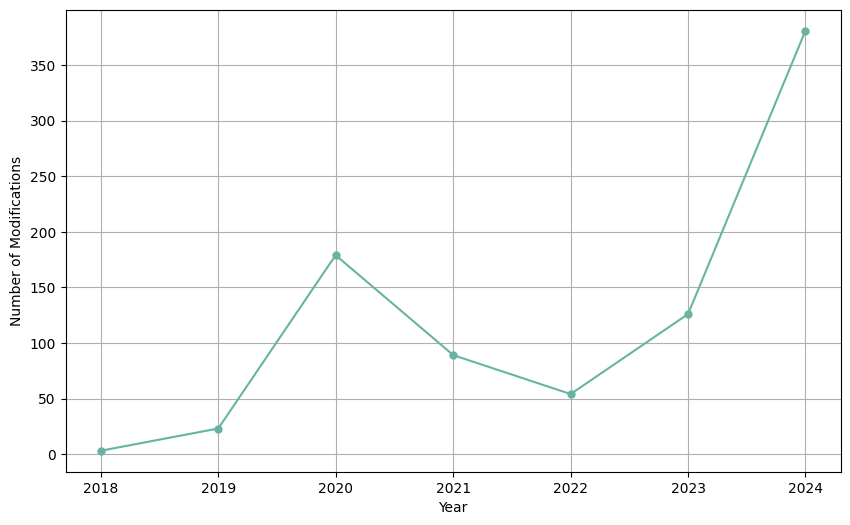

In [23]:
df['dateModified'] = pd.to_datetime(df['dateModified'])

df['Period'] = df['dateModified'].dt.to_period("Y")

modification_counts = df.groupby('Period').size()

plt.figure(figsize=(10, 6))
plt.plot(modification_counts.index.to_timestamp(), modification_counts, marker='o', markersize=5, color='#69b3a2')
plt.xlabel("Year")
plt.ylabel("Number of Modifications")
# plt.title("Number of Dataset Modifications Over Time")
plt.grid(True)
plt.show()

In [24]:
df['dateModified'] = pd.to_datetime(df['dateModified'])

df['Period'] = df['dateModified'].dt.to_period("Y")

modification_counts = df.groupby('Period').size()

fig = px.line(df, x=modification_counts.index.to_timestamp(), y=modification_counts, markers=True,
              labels=dict(x="Year", y = "Number of Modifications"))
fig.update_traces(line_color='#69b3a2')

fig.show()

## Scatter plots to identify if there is any correlational relationships between contentSize VS downloadCount and contentSize VS usabilityRating

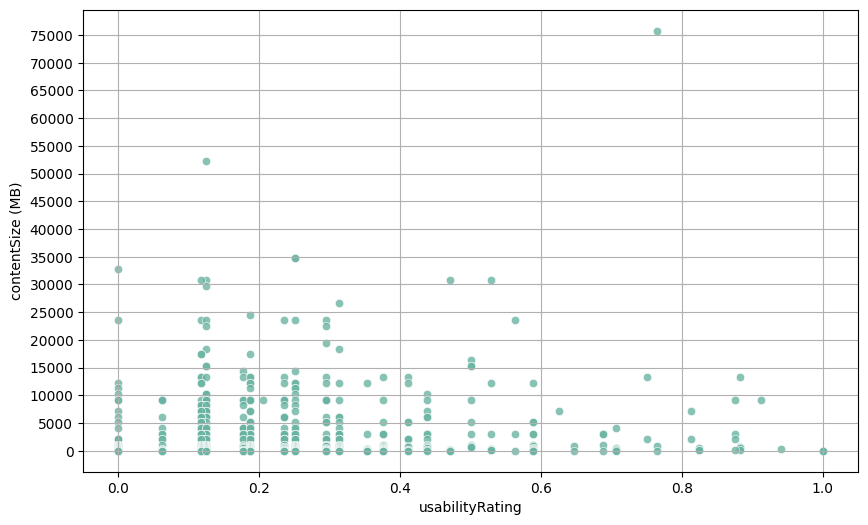

In [25]:
df.sort_values(by="contentSize", ascending=False, inplace=True)

plt.figure(figsize=(10,6))

ax = sns.scatterplot(data=df, x='usabilityRating', y='contentSize', c='#69b3a2', alpha=0.8)

plt.xlabel('usabilityRating')
plt.ylabel('contentSize (MB)')

ax.grid(True)

ax.yaxis.set_major_locator(ticker.MultipleLocator(5000))

plt.show()

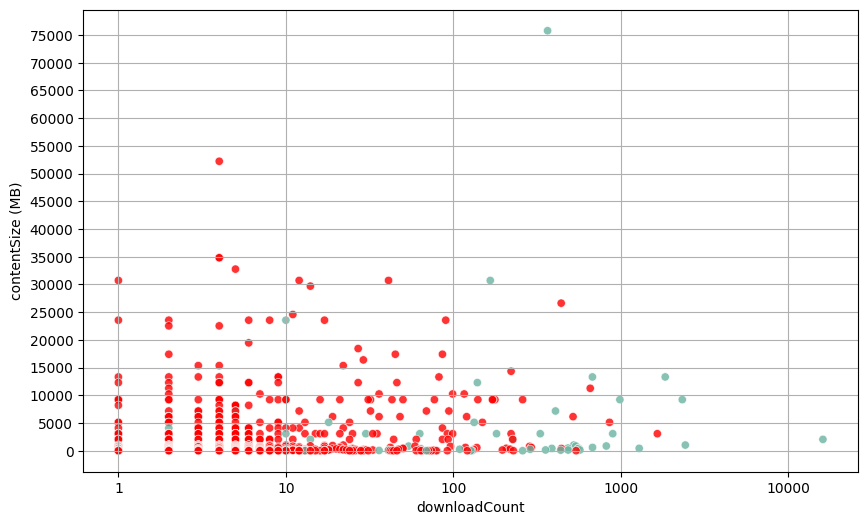

In [26]:
plt.figure(figsize=(10,6))

color = np.where(df['usabilityRating'] > 0.5, '#69b3a2', 'red')

ax = sns.scatterplot(data=df, x='downloadCount', y='contentSize', color=color, alpha=0.8)

plt.xlabel('downloadCount')
plt.ylabel('contentSize (MB)')

ax.set_xscale('log')
ax.grid(True)

ax.xaxis.set_major_locator(ticker.LogLocator(base=10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.MultipleLocator(5000))

plt.show()

In [27]:
fig = px.scatter(df, x="downloadCount", y="contentSize", marginal_x="violin", marginal_y='violin', color = 'usabilityRating', 
                 color_continuous_scale=px.colors.diverging.RdYlGn, log_x=True, labels=dict(contentSize="contentSize (MB)"))

fig.update_xaxes(tickvals=[1, 10, 100, 1000, 10000])

fig.show()